In [27]:
profiles={'cluster': 
          {'in_path': '/project/lindner/moving/summer2018/2019/data-formatted/parallel/', 
           'out_path':'/project/lindner/moving/summer2018/2019/data-intermediate/kmeans/'},
          'nicholas': {'in_path':'D:/programming-no-gdrive/air-pollution/data-intermediate/',
                       'out_path':'D:/programming-no-gdrive/air-pollution/data-intermediate/new_seqs/'}}

In [ ]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pickle
parser = argparse.ArgumentParser()
parser.add_argument("-u", '--user', type=str,
                    help="cluster, nicholas, carroll")
args = parser.parse_args()

In [13]:
if args.user=='nicholas':
    os.chdir('../parallel/')
    os.getcwd()

In [36]:
if args.user=='cluster':
    #from processor_pipeline_nicholas import SequenceFeatureEnricher
    from parallel_scripts.processor_pipeline_nicholas import SequenceBuilder
    import parallel_scripts.d as d

In [40]:
class SequenceFeatureEnricher(object):
    def __init__(self, regression_features=True, std_features=True, kmeans_features=True, masknan: float = None, n_clusters=8):
        self.regression_features = regression_features
        self.std_features = std_features
        self.kmeans_features= kmeans_features
        self.n_clusters=n_clusters
        self.masknan = masknan
        self.sample_sequences = []
        self.sequence_features = []
        # So we can map sequence features back to minmax values for scaling
        self.sequence_features_scalar_map = []
        if regression_features:
            for f in range(d.ENRICH_START, d.NUM_INPUTS):
                self.sequence_features_scalar_map.append(f)
                self.sequence_features_scalar_map.append(f)
        if std_features:
            for f in range(d.ENRICH_START, d.NUM_INPUTS):
                self.sequence_features_scalar_map.append(f)    
    def kmeans_process(self, nd: np.ndarray):
        from sklearn.cluster import KMeans
        print(str(self.n_clusters)+' clusters in K Means:')
        kmeans=KMeans(n_clusters=self.n_clusters, n_jobs=-1, verbose=1, max_iter=50).fit(nd)
        return kmeans.labels_, kmeans.cluster_centers_, kmeans.inertia_
    def process(self, nd: np.ndarray):
        # Add some features
        for sequence in range(0, nd.shape[0]):
            features_to_add = []
            if self.regression_features:
                for f in range(d.ENRICH_START, d.NUM_INPUTS):
                    m = np.nansum(nd[sequence][:, f]) / np.nansum(np.arange(0, nd.shape[1]))
                    b = nd[sequence][:, f][0]

                    features_to_add.extend([m, b])
            if self.std_features:
                for f in range(d.ENRICH_START, d.NUM_INPUTS):
                    features_to_add.append(np.nanstd(nd[sequence][:, f]))
            self.sample_sequences.append(nd[sequence])
            self.sequence_features.append(features_to_add)

In [ ]:
in_path=profiles[args.user]['in_path']
out_path=profiles[args.user]['out_path']

In [17]:
sequences=np.load(open(in_path+'000_sequences.npy', 'rb'))

###From nd
nd=np.load(open(in_path+'windowed_2000.pkl', 'rb'))
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
nd=scaler.fit_transform(nd)
builder=SequenceBuilder(sequence_length=d.SEQUENCE_LENGTH, prediction_window=d.PREDICTION_WINDOW, prediction_names=d.OUTPUT_COLUMNS)
sequences=builder.process(nd)
###

In [ ]:
#Reshaping
data_sequences=sequences
data_sequences = data_sequences.reshape(data_sequences.shape[0], data_sequences.shape[1]*data_sequences.shape[2])

#For all at once
labels_all=[]
cluster_centers_all=[]
inertias=[]
cluster_sizes=[]
for n_clusters in range(4,20,2):
    enricher=SequenceFeatureEnricher(n_clusters=n_clusters)
    labels, cluster_centers,inertia=enricher.kmeans_process(data_sequences)
    labels_all.append(labels)
    cluster_centers_all.append(cluster_centers)
    inertias.append(inertia)
    cluster_sizes.append(n_clusters)
    print(str(n_clusters)+' clusters')
labels_all=np.array(labels_all)
cluster_centers_all=np.array(cluster_centers_all)
inertias=np.array(inertias)
pickle.dump(labels_all, open(out_path+'labels_all_2000.ndarray', 'wb'), protocol=4)
pickle.dump(cluster_centers_all, open(out_path+'cluster_centers_all_2000.ndarray', 'wb'), protocol=4)
pickle.dump(inertias, open(out_path+'inertias_all_2000.ndarray', 'wb'), protocol=4)

In [ ]:
#For individually
#For all at once
site_id='48_201_1034'
labels_all=[]
cluster_centers_all=[]
inertias=[]
number_clusters=[]
for n_clusters in range(4,20,2):
    print(str(n_clusters)+' clusters')
    enricher=SequenceFeatureEnricher(n_clusters=n_clusters)
    labels, cluster_centers,inertia=enricher.kmeans_process(data_sequences)
    pickle.dump(labels, open(out_path+'labels_'+site_id+'_'+str(n_clusters)+'clusters.ndarray', 'wb'), protocol=4)
    pickle.dump(cluster_centers, open(out_path+'cluster_centers_'+site_id+'_'+str(n_clusters)+'clusters.ndarray', 'wb'), protocol=4)
    pickle.dump(inertia, open(out_path+'inertia_'+site_id+'_'+str(n_clusters)+'clusters.ndarray', 'wb'), protocol=4)
    inertias.append(inertia)
    number_clusters.append(n_clusters)

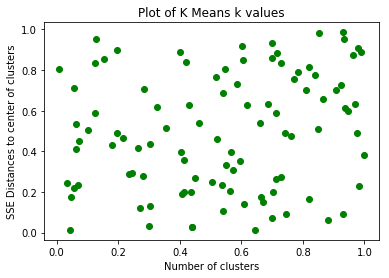

In [17]:
plt.plot(number_clusters, inertias, 'go')
plt.xlabel('Number of clusters')
plt.ylabel('SSE Distances to center of clusters')
plt.title('Plot of K Means k values')
plt.savefig(out_path+'kmeans_plot.png')
plt.show()